In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.linear_model import LogisticRegression
sns.set(style="white")
from sklearn.externals import joblib



data = pd.read_csv('../fichier_csv/exemple.csv')

# Standardisation des données

In [3]:
data

,length,height_left,height_right,margin_low,margin_up,diagonal,id
0,171.76,104.01,103.54,5.21,3.30,111.42,B_1
1,171.87,104.17,104.13,6.00,3.31,112.09,B_2
2,172.00,104.58,104.29,4.99,3.39,111.57,B_3
3,172.49,104.55,104.34,4.44,3.03,113.20,B_4
4,171.65,103.63,103.56,3.77,3.16,113.33,B_5


In [4]:
valeurs = data.iloc[:,[0,1,2,3,4,5]]
etiquettes = data['id']
std_scale = joblib.load('algo_std.pkl')
valeurs_std = std_scale.transform(valeurs)
df_valeurs_std = pd.DataFrame(valeurs_std,columns = ['length', 'height_left', 'height_right', 'margin_low','margin_up','diagonal'])
df_valeurs_std['id'] = etiquettes
data_std = df_valeurs_std.copy()

In [5]:
data_std

,length,height_left,height_right,margin_low,margin_up,diagonal,id
0,-0.592349,-0.189545,-1.176095,0.854075,0.549883,-1.248107,B_1
1,-0.231537,0.348620,0.611755,1.982591,0.592316,-0.521209,B_2
2,0.194877,1.727666,1.096595,0.539805,0.931781,-1.085369,B_3
3,1.802131,1.626760,1.248108,-0.245870,-0.595810,0.683054,B_4
4,-0.953162,-1.467685,-1.115490,-1.202966,-0.044180,0.824094,B_5


# Test de détection des billets

In [6]:
data_acp = data.copy()
data_acp_ind = data.copy()
data_acp.index = data_acp['id']
del data_acp['id']

X = data_acp.values
n_components = 2

pca = PCA(n_components=n_components)
reduction = pca.fit_transform(X)

for i in range(0, n_components):
    data_acp_ind['PC' + str(i + 1)] = reduction[:, i]


In [7]:
data_acp_ind

,length,height_left,height_right,margin_low,margin_up,diagonal,id,PC1,PC2
0,171.76,104.01,103.54,5.21,3.30,111.42,B_1,-0.841506,-0.647904
1,171.87,104.17,104.13,6.00,3.31,112.09,B_2,-0.928110,0.232185
2,172.00,104.58,104.29,4.99,3.39,111.57,B_3,-0.699001,0.190722
3,172.49,104.55,104.34,4.44,3.03,113.20,B_4,0.910038,0.843560
4,171.65,103.63,103.56,3.77,3.16,113.33,B_5,1.558578,-0.618563


In [8]:
data_test = data_std.copy()
data_test_ind = data_std.copy()
data_test.index = data_test['id']
del data_test['id']

X = data_test.values

In [9]:
clf2 = joblib.load('algo_reg_log.pkl')

probaClasses = clf2.predict_proba(X)

a = pd.Series(probaClasses[:,0],name='probas')
test =pd.concat([data,a],axis=1)

test['verif']=test['probas'] >=0.5
test

,length,height_left,height_right,margin_low,margin_up,diagonal,id,probas,verif
0,171.76,104.01,103.54,5.21,3.30,111.42,B_1,0.980579,True
1,171.87,104.17,104.13,6.00,3.31,112.09,B_2,0.997805,True
2,172.00,104.58,104.29,4.99,3.39,111.57,B_3,0.986964,True
3,172.49,104.55,104.34,4.44,3.03,113.20,B_4,0.041690,False
4,171.65,103.63,103.56,3.77,3.16,113.33,B_5,0.003680,False


# Graphique 

[Text(0,0.5,'PC2'), Text(0.5,0,'PC1'), None]

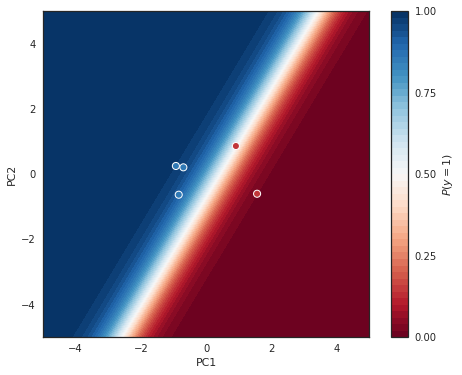

In [10]:
#Regression 
y = test['verif']
clf = joblib.load('algo_reg_log_plot.pkl')

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]


probs = clf.predict_proba(grid)[:,1].reshape(xx.shape) #probabilité d'appartenir à True

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs,50, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(data_acp_ind['PC1'], data_acp_ind['PC2'], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",

       xlabel="PC1", ylabel="PC2")